# StreamBasedCache

## Install dependencies

In [1]:
try:
    import google.colab
    GOOGLE_COLAB = True
except ImportError:
    GOOGLE_COLAB = False

In [2]:
if GOOGLE_COLAB:
    !sudo apt-get -yqq install libsnappy-dev

In [3]:
if GOOGLE_COLAB:
    !pip install -q python-snappy Faker pyproj
    !pip install -q -U bokeh

In [4]:
if GOOGLE_COLAB:
    !pip install "git+https://github.com/ostrokach/beam.git@feature/streambasedcache#egg=apache_beam[gcp]&subdirectory=sdks/python"

## Imports

In [5]:
from __future__ import print_function

import copy
import itertools
import json
import logging
import os
import pickle
import shutil
import tempfile
import time
import uuid
from collections import Counter, OrderedDict
from datetime import datetime

import apache_beam as beam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyproj
import pytz
import requests
import tqdm
from apache_beam.io.filesystems import FileSystems
from apache_beam.io.gcp.pubsub import PubsubMessage
from apache_beam.options.pipeline_options import (GoogleCloudOptions,
                                                  PipelineOptions)
from apache_beam.runners.direct.direct_runner import BundleBasedDirectRunner
from apache_beam.runners.interactive import caching
from apache_beam.transforms import combiners, window
from apache_beam.transforms.ptransform import ptransform_fn
from faker import Faker
from google.api_core import exceptions as gexc
from google.cloud import pubsub

from bokeh.io import output_notebook, push_notebook, show
from bokeh.layouts import row
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

In [6]:
pd.set_option("max_columns", 100)

In [7]:
%matplotlib inline

## Parameters

In [8]:
if GOOGLE_COLAB:
    from google.colab import auth
    auth.authenticate_user()

In [9]:
#@title Google Cloud Project Info { display-mode: "form" }
project_id = "strokach-playground" #@param {type:"string"}
gcs_temp_location = "gs://strokach/dataflow_temp" #@param {type:"string"}

In [10]:
NOTEBOOK_NAME = "streambasedcache_new_york_taxirides"
try:
    os.mkdir(NOTEBOOK_NAME)
except OSError:
    pass

In [11]:
options = PipelineOptions(
    temp_location=gcs_temp_location, streaming=True, project=project_id
)
options.display_data()

{'project': 'strokach-playground',
 'streaming': True,
 'temp_location': 'gs://strokach/dataflow_temp'}

In [12]:
try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    print("No autoreload")

## Load data

In [13]:
input_file = "new_york_taxirides_to_events/new-york-taxi-events.parquet"

In [14]:
events_df = pq.read_table(input_file).to_pandas()
events_df.head(2)

,event_type,timestamp,longitude,latitude,trip_miles,trip_total,timestamp_seconds,utm_x,utm_y
0,start,2015-12-01 00:00:00,-73.979942,40.765381,NaN,NaN,1.448928e+09,-8.235410e+06,4.977797e+06
1,stop,2015-12-01 00:00:00,-73.974548,40.791641,2.62,21.36,1.448928e+09,-8.234809e+06,4.981657e+06


In [15]:
pt = pq.ParquetFile(input_file)
print("Num row groups:", pt.num_row_groups)
pt.read_row_group(0).to_pandas(integer_object_nulls=True).head(2)

Num row groups: 2204


,event_type,timestamp,longitude,latitude,trip_miles,trip_total,timestamp_seconds,utm_x,utm_y
0,start,2015-12-01 00:00:00,-73.979942,40.765381,NaN,NaN,1.448928e+09,-8.235410e+06,4.977797e+06
1,stop,2015-12-01 00:00:00,-73.974548,40.791641,2.62,21.36,1.448928e+09,-8.234809e+06,4.981657e+06


In [16]:
def generate_taxi_events(input_file, **kwargs):
    pf = pq.ParquetFile(input_file)
    for row_group_index in range(pf.num_row_groups):
        table = pf.read_row_group(row_group_index, **kwargs)
        data = table.to_pydict()
        columns = list(data)
        for row_index in range(len(data[columns[0]])):
            row = OrderedDict([(c, data[c][row_index]) for c in columns])
            yield row

In [17]:
pd.DataFrame(itertools.islice(generate_taxi_events(input_file), 2))

,event_type,timestamp,longitude,latitude,trip_miles,trip_total,timestamp_seconds,utm_x,utm_y
0,start,2015-12-01 00:00:00,-73.979942,40.765381,NaN,NaN,1.448928e+09,-8.235410e+06,4.977797e+06
1,stop,2015-12-01 00:00:00,-73.974548,40.791641,2.62,21.36,1.448928e+09,-8.234809e+06,4.981657e+06


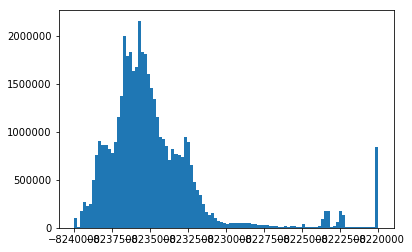

In [79]:
MERCATOR_X_RANGE = (-8240000, -8220000)

fg, ax = plt.subplots()
_ = ax.hist(
    np.clip(events_df["utm_x"], *MERCATOR_X_RANGE), bins=100, range=MERCATOR_X_RANGE
)

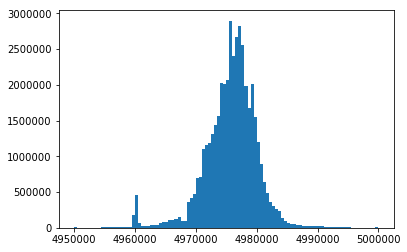

In [19]:
MERCATOR_Y_RANGE = (4950000, 5000000)

fg, ax = plt.subplots()
_ = ax.hist(
    np.clip(events_df["utm_y"], *MERCATOR_Y_RANGE), bins=100, range=MERCATOR_Y_RANGE
)

## Workflow

In [37]:
seconds_per_batch = (15 * 60)
events_df["group_id"] = (events_df["timestamp_seconds"] // seconds_per_batch * seconds_per_batch).astype(np.int)

In [74]:
import bokeh
bokeh.palettes.d3['Category20b'][3]

[u'#393b79', u'#5254a3', u'#6b6ecf']

In [80]:
from bokeh.core.properties import value
from bokeh.io import output_notebook, push_notebook, show
from bokeh.layouts import row
from bokeh.models import ColumnDataSource, Label, LabelSet, Legend, LegendItem, Range1d
from bokeh.models.annotations import Title
from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import Vendors, get_provider
from bokeh.transform import factor_cmap, factor_mark

output_notebook()

if GOOGLE_COLAB:
    print("Interactive plot does not work on colab yet!")


# Colormap
# cmap = bokeh.palettes.d3["Category10"][4]
cmap = bokeh.palettes.d3["Category20b"][20]
colors = [cmap[1], cmap[-2]]

# Source of data
source = ColumnDataSource(data=dict(x=[], y=[], event_type=[]))

# Background map
fg = figure(
    x_range=MERCATOR_X_RANGE,
    y_range=MERCATOR_Y_RANGE,
    x_axis_type="mercator",
    y_axis_type="mercator",
    title_location="above",
    plot_height=600,
)
fg.add_tile(get_provider(Vendors.CARTODBPOSITRON))

# Scatterplot
fg.circle(
    x="x",
    y="y",
    source=source,
    size=2,
    color=factor_cmap("event_type", colors, ["start", "stop"]),
    fill_alpha=0.8,
    #     legend=value("start", "stop"),
    #     legend=[value(x) for x in ["start", "stop"]],
)

# Legend
start = fg.circle(x=[], y=[], color=colors[0])
stop = fg.circle(x=[], y=[], color=colors[1])
legend = Legend(items=[("start", [start]), ("stop", [stop])])
fg.add_layout(legend)

# Updates
handle = show(fg, notebook_handle=True)

days_of_week = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
for index, gp in events_df.sample(frac=0.1).groupby(["group_id"]):
    dt = datetime.utcfromtimestamp(index).replace(
        tzinfo=pytz.UTC
    )  # .astimezone(pytz.timezone('US/Eastern'))
    dt_str = days_of_week[dt.weekday()] + " " + dt.strftime("%b %d %Y %I:%M:%S %p")
    fg.title.text = dt_str
    fg.title.align = "center"
    source.data = {
        "x": gp["utm_x"].values,
        "y": gp["utm_y"].values,
        "event_type": gp["event_type"].values,
    }
    push_notebook(handle=handle)
    time.sleep(0.2)

Loading BokehJS ...

KeyboardInterrupt: 

### Write dataset to cache

In [ ]:
sub_client = pubsub.SubscriberClient()

In [ ]:
subscription_name = "projects/{}/subscriptions/taxirides-realtime-sub".format(project_id)

try:
    sub_client.create_subscription(
        subscription_name,
        "projects/pubsub-public-data/topics/taxirides-realtime",
    )
except gexc.AlreadyExists:
    sub_client.delete_subscription(subscription_name)
    sub_client.create_subscription(
        subscription_name,
        "projects/pubsub-public-data/topics/taxirides-realtime",
    )

### Process data from subscription to cache

In [ ]:
LONGITUDE_RANGE = (-74.747, -73.969)  # (-74.07, -73.90)
LATITUDE_RANGE = (40.699, 40.720)  # (40.73, 40.77)

In [ ]:
x_min, y_min = geographic_to_utm(longitude=LONGITUDE_RANGE[0], latitude=LATITUDE_RANGE[0])
x_max, y_max = geographic_to_utm(longitude=LONGITUDE_RANGE[1], latitude=LATITUDE_RANGE[1])

MERCATOR_X_RANGE = (x_min, x_max)
MERCATOR_Y_RANGE = (y_min, y_max)

In [ ]:
raise Exception

In [ ]:
try:
    p_result.cancel()
except NameError:
    pass

In [ ]:
temp = caching.PubSubBasedCache(
    "projects/{}/topics/temp-2".format(project_id), mode="overwrite"
)

In [ ]:
class ToList(beam.PTransform):
  """A global CombineFn that condenses a PCollection into a single list."""

  def __init__(self, label='ToList'):  # pylint: disable=useless-super-delegation
    super(ToList, self).__init__(label)

  def expand(self, pcoll):
    return pcoll | self.label >> beam.CombineGlobally(combiners.ToListCombineFn()).without_defaults()


In [ ]:
class BuildRecordFn(beam.DoFn):
    def __init__(self):
        super(BuildRecordFn, self).__init__()

    def process(self, elements, window=beam.DoFn.WindowParam):
        # window_start = window.start.to_utc_datetime()
        window_end = window.end.to_utc_datetime()
        return [(window_end, elements)]

In [ ]:
p = beam.Pipeline(runner=BundleBasedDirectRunner(), options=options)

out = (
    p
    | "Read" >> beam.io.ReadFromPubSub(subscription=subscription_name, with_attributes=True)
#     | "echo" >> beam.Map(lambda e: print(e) or e)
    | "Decode PubSub message" >> beam.ParDo(DecodeTaxiMessage())
    | "Load JSON" >> beam.Map(load_json)
    | "Filter coords" >> beam.ParDo(SelectWithinGeographicRange(LONGITUDE_RANGE, LATITUDE_RANGE))
    | "Add UTM coords" >> beam.Map(add_mercator_coords)
    | "Window" >> beam.WindowInto(window.FixedWindows(2 * 60))
    | "Combine" >> ToList()
    | 'AddWindowEndTimestamp' >> beam.ParDo(BuildRecordFn())
#     | "echo" >> beam.Map(lambda e: print(e) or e)
    | "Write" >> temp.writer()
)

p_result = p.run()

In [ ]:
for row in itertools.islice(temp.read(), 2):
    print(row)

In [ ]:
row[0].strftime("%Y-%m-%d %H:%M:%S")

### Interactive dashboard

In [ ]:
import logging

logging.getLogger("google.auth._default").setLevel(logging.CRITICAL)

In [ ]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.tile_providers import Vendors, get_provider
from bokeh.models.annotations import Title

In [ ]:
bokeh.plotting.

In [ ]:
output_notebook()

if GOOGLE_COLAB:
    print("Interactive plot does not work on colab yet!")

# range bounds supplied in web mercator coordinates
fig = figure(
    x_range=MERCATOR_X_RANGE,
    y_range=MERCATOR_Y_RANGE,
    x_axis_type="mercator",
    y_axis_type="mercator",
#     plot_height=600,
)
fig.add_tile(get_provider(Vendors.CARTODBPOSITRON))

source = ColumnDataSource(data=dict(x=[], y=[]))

fig.circle(x="x", y="y", size=2, fill_color="blue", fill_alpha=0.8, source=source)

handle = show(fig, notebook_handle=True)

while True:
    for i, row in enumerate(temp.read()):
        title = Title()
        title.text = row[0].strftime("%Y-%m-%d %H:%M:%S")
        fig.title = title
        source.stream({"x": [e["x"] for e in row[1]], "y": [e["y"] for e in row[1]]})
        push_notebook(handle=handle)